In [159]:
import tables as tb
import pandas as pd
import numpy as np

from invisible_cities.io import dst_io as dio
from utils.plotting_utils import plot_3d_vox, plot_cloud_voxels_and_hits

Voy a juntar a mi dataset de salida del labelling los datos obtenidos por isaura. En principio los dos primeros los hago a mano, así se lo paso a JA cuanto antes. 

Pero la idea es pronto hacerlo automáticamente en la producción, o si no es en la producción directamente peus con un script a parte... más bien eso porque supongo q será abrir dos archivos, dentro con una función hacer la unición (la función la voy a tener ya para ahora así que guay)

En mi mente, como isaura es simplemente un DF con una lista de información por cada traza detectada, voy a intentar unirlo a la información de eventos a ver si puedo (o al revés), así que como mucho tendré una, dos o tres líneas por evento, q la información base la comparten pero difieren entre ellas en información de la traza (porque cada línea representará una traza)

Puedo añadir un bool que sea add_isaura o algo así, avisar de que la condición es que tenga el mismo path q los beershebas q se van a etiquetar pero donde ponga beersheba ahora ponga isaura (y si no pues renombrar) y así pues si hay un True en add_isaura lo que hacemos es con un if en create_final_dataframes (a la altura

In [105]:
labelled_beersheba_file = 'prueba_cut25_addisaura.h5'

In [106]:
with tb.open_file(labelled_beersheba_file) as h5in:
    print(h5in)

prueba_cut25_addisaura.h5 (File) ''
Last modif.: 'Tue Jan 25 12:14:57 2022'
Object Tree: 
/ (RootGroup) ''
/DATASET (Group) ''
/DATASET/BeershebaVoxels (Table(487973,), shuffle, zlib(4)) ''
/DATASET/BinsInfo (Table(1,), shuffle, zlib(4)) ''
/DATASET/EventsInfo (Table(2425,), shuffle, zlib(4)) ''
/DATASET/MCHits (Table(604633,), shuffle, zlib(4)) ''
/DATASET/MCVoxels (Table(132192,), shuffle, zlib(4)) ''



In [250]:
isaura_file = 'Tl208_NEW_v1_03_01_nexus_v5_03_04_cut24.isaura_6207.root.h5'

In [251]:
with tb.open_file(isaura_file) as h5in:
    print(h5in)

Tl208_NEW_v1_03_01_nexus_v5_03_04_cut24.isaura_6207.root.h5 (File) ''
Last modif.: 'Mon Jan 24 16:20:05 2022'
Object Tree: 
/ (RootGroup) ''
/DST (Group) ''
/DST/Events (Table(826,), shuffle, zlib(4)) 'KDST Events'
/Filters (Group) ''
/Filters/hits_select (Table(587,), shuffle, zlib(4)) 'Event has passed filter flag'
/Filters/topology_select (Table(587,), shuffle, zlib(4)) 'Event has passed filter flag'
/MC (Group) ''
/MC/event_mapping (Table(587,), shuffle, zlib(4)) ''
/MC/generators (Table(0,), shuffle, zlib(4)) ''
/MC/hits (Table(147138,), shuffle, zlib(4)) ''
/MC/particles (Table(17551,), shuffle, zlib(4)) ''
/Run (Group) ''
/Run/events (Table(587,), shuffle, zlib(4)) 'event info table'
/Run/runInfo (Table(587,), shuffle, zlib(4)) 'run info table'
/Summary (Group) ''
/Summary/Events (Table(587,), shuffle, zlib(4)) 'Event summary information'
/Tracking (Group) ''
/Tracking/Tracks (Table(818,), shuffle, zlib(4)) 'Track information'



## Function to add isaura by hand

In [109]:
def add_isaura(labelled_beersheba_file):
    #Leo el DF con la info de los eventos del fichero beersheba
    eventsInfo = dio.load_dst(labelled_beersheba_file, 'DATASET', 'EventsInfo')
    
    #Creo el DF donde voy a guardar toda la info
    isaura_info = pd.DataFrame()
    
    for basename, info_df in eventsInfo.groupby('basename'):
        #Creo un mapa entre event_id y dataset_id
        dataset_id, event_id = info_df.dataset_id.values, info_df.event_id.values
        dct_map = {ev_id:dat_id for ev_id, dat_id in zip(event_id, dataset_id)}
    
        #Cambio el path para que sea de isaura
        beersh_path = info_df.pathname.values[0] + '/' + basename
        isaura_path = beersh_path.replace('beersheba', 'isaura')
    
        #Leo la info de Tracking/Tracks del fichero de isaura
        isaura_info_event = dio.load_dst(isaura_path, 'Tracking', 'Tracks')
    
        #Añado la columna de dataset_id a cada fila correspondiente y añado al DF general
        isaura_info_event = isaura_info_event.assign(dataset_id = isaura_info_event.event.map(dct_map))
        isaura_info = isaura_info.append(isaura_info_event)
        
    #Ordeno columnas y eventos
    isaura_info = isaura_info[['dataset_id'] + [col for col in isaura_info.columns if col != 'dataset_id']]
    isaura_info = isaura_info.sort_values(['dataset_id', 'trackID'], ascending = [True, True])
    isaura_info = isaura_info.reset_index(drop = True)
    return isaura_info

In [110]:
isaura_info = add_isaura(labelled_beersheba_file)

In [116]:
isaura_info

,dataset_id,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,0,100000025,0,1.595240,93.639610,28,3229,1,-20.5,-88.5,...,91.537358,-14.542260,-16.452531,85.790563,0.801203,0.349342,0.000000,15.0,15.0,15.0
1,1,100000026,0,1.599146,73.174728,14,3302,1,-25.5,14.5,...,310.983385,-16.639357,23.535446,337.742428,0.686645,0.562192,0.000000,15.0,15.0,15.0
2,2,100000027,0,1.604770,72.426407,27,3373,1,-12.5,67.5,...,210.702546,21.168560,83.200742,149.927893,0.528562,0.462272,0.000000,15.0,15.0,15.0
3,3,100000028,0,1.597004,70.980762,19,2925,1,-28.5,53.5,...,348.143087,-11.950207,70.345439,294.119308,0.819299,0.661542,0.000000,15.0,15.0,15.0
4,4,100000029,0,1.623576,62.193966,21,3493,1,-122.5,-132.5,...,280.290087,-95.006624,-105.782912,321.185558,0.716586,0.459579,0.000000,15.0,15.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3447,2421,50000565,1,0.046302,25.980762,2,100,2,24.5,48.5,...,490.599460,24.993352,75.577575,499.855687,0.043237,0.003066,0.000000,15.0,15.0,15.0
3448,2422,50000566,0,1.448790,62.193966,19,3398,1,-51.5,16.5,...,151.719351,-44.963619,46.788368,146.566507,0.849370,0.380910,0.000000,15.0,15.0,15.0
3449,2423,50000567,0,1.433646,47.193966,16,3539,2,-141.5,-129.5,...,451.164767,-124.095341,-94.617111,474.901966,0.898927,0.476935,0.007080,15.0,15.0,15.0
3450,2423,50000567,1,0.055338,0.000000,1,153,2,-89.5,-144.5,...,471.367192,-85.757516,-138.404899,471.367192,0.055338,0.055338,0.055338,15.0,15.0,15.0


In [103]:
#Guardo este nuevo DF en el fichero labelleado de beersheba
#Esta guardadura en la realidad la haré fuera de la función i guess (es decir, el isaura info lo
#iré appendeando a otro DF y luego lo añado de golpe... de hecho puedo probar a ver eso, y de paso 
#ordenarlo)
#with tb.open_file(labelled_beersheba_file, 'a') as h5out:
    #dio.df_writer(h5out, isaura_info  , 'DATASET', 'IsauraInfo')

In [104]:
with tb.open_file(labelled_beersheba_file, 'a') as h5out:
    print(h5out)

prueba_cut24_addisaura.h5 (File) ''
Last modif.: 'Tue Jan 25 12:17:51 2022'
Object Tree: 
/ (RootGroup) ''
/DATASET (Group) ''
/DATASET/BeershebaVoxels (Table(619074,), shuffle, zlib(4)) ''
/DATASET/BinsInfo (Table(1,), shuffle, zlib(4)) ''
/DATASET/EventsInfo (Table(3059,), shuffle, zlib(4)) ''
/DATASET/IsauraInfo (Table(4329,), shuffle, zlib(4)) ''
/DATASET/MCHits (Table(763078,), shuffle, zlib(4)) ''
/DATASET/MCVoxels (Table(167700,), shuffle, zlib(4)) ''



## To add isaura automatically in the labelling ive implemented some lines and a function in the repository

### Here we are going to check if the adding was performed correctly in some example trials

In [256]:
beersh_isaura_path = 'prueba_cut24_productionisaura.h5'

In [257]:
with tb.open_file(beersh_isaura_path) as h5in:
    print(h5in)

prueba_cut24_productionisaura.h5 (File) ''
Last modif.: 'Tue Jan 25 19:10:34 2022'
Object Tree: 
/ (RootGroup) ''
/DATASET (Group) ''
/DATASET/BeershebaVoxels (Table(619074,), shuffle, zlib(4)) ''
/DATASET/BinsInfo (Table(1,), shuffle, zlib(4)) ''
/DATASET/EventsInfo (Table(3059,), shuffle, zlib(4)) ''
/DATASET/IsauraInfo (Table(4329,), shuffle, zlib(4)) ''
/DATASET/MCHits (Table(763078,), shuffle, zlib(4)) ''
/DATASET/MCVoxels (Table(167700,), shuffle, zlib(4)) ''



In [258]:
isauraInfo = dio.load_dst(beersh_isaura_path, 'DATASET', 'IsauraInfo')
beersh_vox = dio.load_dst(beersh_isaura_path, 'DATASET', 'BeershebaVoxels')
MC_hits    = dio.load_dst(beersh_isaura_path, 'DATASET', 'MCHits')

In [259]:
idx = 15

In [260]:
beersh_vox_ev = beersh_vox[beersh_vox.dataset_id == idx]
isauraInfo_ev = isauraInfo[isauraInfo.dataset_id == idx]
MC_hits_ev    = MC_hits[MC_hits.dataset_id == idx]

In [249]:
isauraInfo

,dataset_id,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,0,48000024,0,1.816530,84.852814,27,3506,1,-21.5,104.5,...,265.197423,48.867331,120.819595,318.576824,0.848863,0.150393,0.000000,15.0,15.0,15.0
1,1,48000025,0,1.547930,154.387931,27,3874,1,-4.5,129.5,...,247.955650,0.003369,190.670848,272.650474,0.805917,0.106594,0.000000,15.0,15.0,15.0
2,2,48000026,0,1.435224,73.174728,21,3212,1,-42.5,144.5,...,353.496318,-18.683013,192.645764,311.856566,0.878538,0.090185,0.000000,15.0,15.0,15.0
3,3,48000027,0,1.772665,128.407169,33,3773,1,-117.5,-109.5,...,243.575877,-87.751758,0.311193,287.448686,1.229090,0.115980,0.000000,15.0,15.0,15.0
4,4,48000028,0,1.806457,129.155490,37,4076,1,69.5,77.5,...,206.393812,76.274017,171.655661,245.422957,0.194869,0.113082,0.000000,15.0,15.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4324,3057,48000617,1,0.680159,40.980762,10,2259,2,-106.5,29.5,...,337.649192,-85.636651,41.825826,361.690956,0.545137,0.413712,0.278690,15.0,15.0,15.0
4325,3058,48000618,0,1.412698,77.193966,18,3315,4,-31.5,-114.5,...,159.117949,-2.822980,-71.780258,200.009520,0.770071,0.279007,0.000000,15.0,15.0,15.0
4326,3058,48000618,1,0.135622,0.000000,1,400,4,41.5,-24.5,...,444.049392,44.584484,-19.998248,444.049392,0.135622,0.135622,0.135622,15.0,15.0,15.0
4327,3058,48000618,2,0.033652,0.000000,1,111,4,-34.5,-48.5,...,142.721207,-33.496649,-42.330877,142.721207,0.033652,0.033652,0.033652,15.0,15.0,15.0


In [238]:
def isaura_blob_positions(isauraInfo_ev, coords = ['x', 'y', 'z']):
    blob1 = np.array((isauraInfo_ev.blob1_x.values, isauraInfo_ev.blob1_y.values, isauraInfo_ev.blob1_z.values)).T
    blob2 = np.array((isauraInfo_ev.blob2_x.values, isauraInfo_ev.blob2_y.values, isauraInfo_ev.blob2_z.values)).T
    blob_coords = np.append(blob1, blob2, axis = 0)
    
    positions_df = pd.DataFrame(blob_coords, columns = coords)
    
    #added for plotting
    positions_df['segclass'] = np.zeros(len(positions_df)) + 3
    return positions_df

In [239]:
blob_pos = isaura_blob_positions(isauraInfo_ev)

In [240]:
blob_pos

,x,y,z,segclass
0,-9.344490,91.430704,303.199539,3.0
1,-161.359150,11.231061,446.623603,3.0
2,0.762824,101.296854,244.872634,3.0
3,-162.220036,5.682624,447.173788,3.0


In [241]:
beersh_vox_ev

,xbin,ybin,zbin,energy,binclass,MC_ener,ratio,segclass,dataset_id
3100,-35,0,111,0.000162,0,NaN,NaN,4,15
3101,-35,0,112,0.000032,0,NaN,NaN,4,15
3102,-35,1,111,0.000252,0,NaN,NaN,4,15
3103,-35,2,111,0.000040,0,NaN,NaN,4,15
3104,-34,-1,112,0.000056,0,NaN,NaN,4,15
...,...,...,...,...,...,...,...,...,...
3326,1,19,60,0.000401,0,NaN,NaN,5,15
3327,1,19,61,0.003314,0,NaN,NaN,5,15
3328,1,19,75,0.002962,0,NaN,NaN,5,15
3329,1,20,61,0.000121,0,NaN,NaN,5,15


<IPython.core.display.Javascript object>


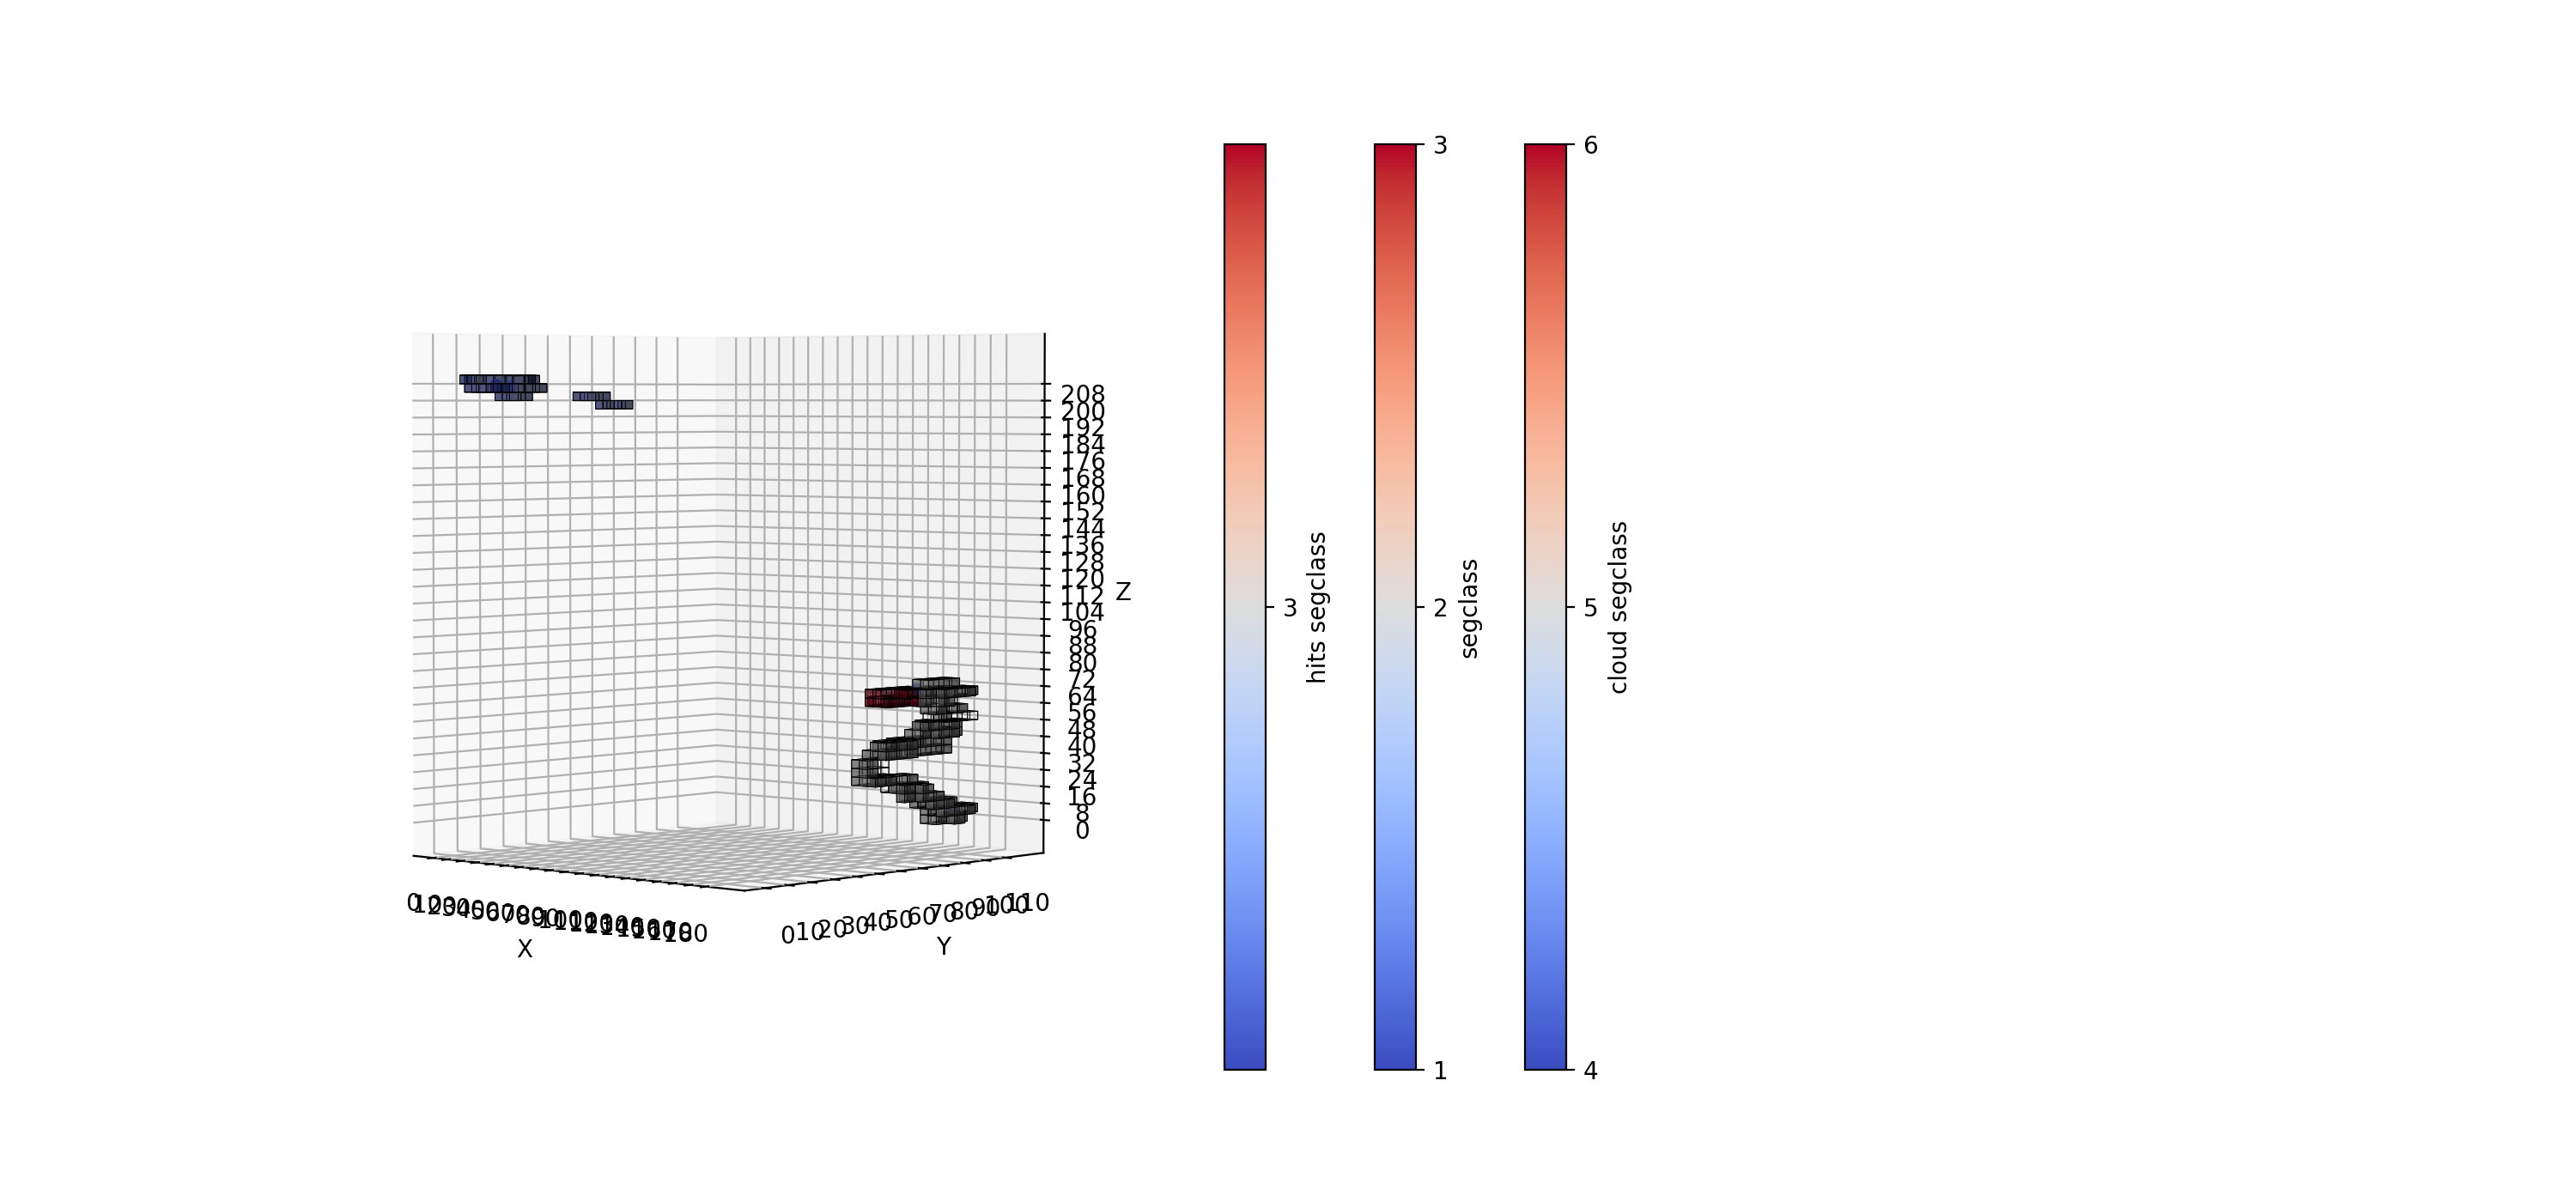

In [242]:
%matplotlib notebook
plot_cloud_voxels_and_hits(beersh_vox_ev, blob_pos, voxel_size = (5, 5, 4), opacity = [0, 0.5, 1])